# Analyse de densité de trafic et identification des zones de congestion

### Configuration de Kafka et Spark

In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, lit, count, from_json
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType
from kafka import KafkaProducer, KafkaConsumer
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
from datetime import datetime, timedelta

# ========================== Kafka Configuration ========================== #
KAFKA_BOOTSTRAP_SERVERS = 'kafka1:9092'
KAFKA_TOPIC = 'air_traffic_density'

# ========================== Définition des Zones ========================== #
zones = [
    {"name": "Paris", "lamin": 48.5, "lamax": 49.5, "lomin": 1.5, "lomax": 3.0},
    {"name": "London", "lamin": 51.0, "lamax": 52.0, "lomin": -1.0, "lomax": 0.5},
    {"name": "Frankfurt", "lamin": 49.5, "lamax": 50.5, "lomin": 8.0, "lomax": 9.0},
    {"name": "Madrid", "lamin": 40.0, "lamax": 41.0, "lomin": -4.0, "lomax": -3.0},
    {"name": "Rome", "lamin": 41.5, "lamax": 42.5, "lomin": 12.0, "lomax": 13.0}
]

# ========================== Initialisation Spark ========================== #
spark = SparkSession.builder \
    .appName("AirTrafficDensityKafkaBatch") \
    .config("spark.sql.session.timeZone", "UTC") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.3.1") \
    .getOrCreate()

In [11]:
# ========================== Fonction Kafka Producer ========================== #
def create_kafka_producer():
    """Créer un producteur Kafka"""
    return KafkaProducer(
        bootstrap_servers=KAFKA_BOOTSTRAP_SERVERS,
        value_serializer=lambda v: json.dumps(v).encode('utf-8')
    )

### Envoi et réception des données

In [12]:
# ========================== Fonction pour récupérer les données ========================== #
def fetch_traffic_data(lamin, lamax, lomin, lomax):
    """Récupère les données de trafic aérien depuis OpenSky"""
    url = "https://opensky-network.org/api/states/all"
    params = {"lamin": lamin, "lamax": lamax, "lomin": lomin, "lomax": lomax}
    response = requests.get(url, params=params)
    
    if response.status_code != 200:
        return None
    return response.json()

In [13]:
# ========================== Récupérer les 8 heures passées ========================== #
def fetch_and_send_traffic_data(zones, producer, interval_minutes=15):
    """Récupère et envoie les données des 8 dernières heures à intervalles de 15 minutes"""
    all_data = []
    
    end_time = datetime.utcnow()  # Heure actuelle en UTC
    start_time = end_time - timedelta(hours=8)  # 8 heures avant
    
    timestamps = [int((start_time + timedelta(minutes=i)).timestamp()) for i in range(0, 8 * 60, interval_minutes)]
    
    for timestamp in timestamps:
        for zone in zones:
            data = fetch_traffic_data(zone["lamin"], zone["lamax"], zone["lomin"], zone["lomax"])
            
            if data and 'states' in data and data['states']:
                num_aircraft = len(data['states'])
                
                # Préparer le message pour Kafka
                message = {
                    "timestamp": timestamp,
                    "zone": zone["name"],
                    "aircraft_count": num_aircraft,
                    "lamin": zone["lamin"],
                    "lamax": zone["lamax"],
                    "lomin": zone["lomin"],
                    "lomax": zone["lomax"]
                }
                
                # Envoyer à Kafka
                producer.send(KAFKA_TOPIC, value=message)
                
                entry = {"timestamp": timestamp, "zone": zone["name"], "aircraft_count": num_aircraft}
                all_data.append(entry)
                
                print(f"[{datetime.utcfromtimestamp(timestamp)}] Zone {zone['name']}: {num_aircraft} avions détectés")
            
            time.sleep(2)  # Pause pour éviter de surcharger l'API
    
    # Vider le producteur
    producer.flush()
    
    return all_data

In [14]:
# ========================== Lecture des données Kafka en batch ========================== #
def read_kafka_data_batch(spark):
    """Lire les données Kafka en mode batch"""
    # Définir le schéma pour les messages Kafka
    schema = StructType([
        StructField("timestamp", IntegerType(), True),
        StructField("zone", StringType(), True),
        StructField("aircraft_count", IntegerType(), True),
        StructField("lamin", DoubleType(), True),
        StructField("lamax", DoubleType(), True),
        StructField("lomin", DoubleType(), True),
        StructField("lomax", DoubleType(), True)
    ])
    
    # Lire depuis Kafka en mode batch
    df = spark.read \
        .format("kafka") \
        .option("kafka.bootstrap.servers", KAFKA_BOOTSTRAP_SERVERS) \
        .option("subscribe", KAFKA_TOPIC) \
        .option("startingOffsets", "earliest") \
        .option("endingOffsets", "latest") \
        .load()
    
    # Parser la colonne de valeur
    parsed_df = df.select(
        from_json(col("value").cast("string"), schema).alias("data")
    ).select("data.*")
    
    # Convertir le timestamp en datetime
    parsed_df = parsed_df.withColumn(
        "datetime", 
        col("timestamp").cast(TimestampType())
    )
    
    return parsed_df

### Exploitation, interprétation et visualisation des données

In [15]:
# ========================== Analyse et Visualisation ========================== #
def analyze_density(df):
    """Génère des visualisations sur le trafic aérien"""
    pd_df = df.toPandas()
    
    # Évolution du trafic dans le temps
    plt.figure(figsize=(14, 8))
    for zone in pd_df["zone"].unique():
        zone_data = pd_df[pd_df["zone"] == zone]
        plt.plot(zone_data["datetime"], zone_data["aircraft_count"], marker='o', linestyle='-', label=zone)
    
    plt.title("Évolution du trafic aérien dans le temps")
    plt.xlabel("Heure")
    plt.ylabel("Nombre d'avions")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.savefig("evolution_trafic.png")

    # Densité moyenne par zone
    plt.figure(figsize=(12, 6))
    avg_density = pd_df.groupby("zone")["aircraft_count"].mean().sort_values(ascending=False)
    sns.barplot(x=avg_density.index, y=avg_density.values)
    plt.title("Densité moyenne du trafic aérien par zone")
    plt.xlabel("Zone")
    plt.ylabel("Nombre moyen d'avions")
    plt.xticks(rotation=45)
    plt.savefig("densite_moyenne.png")

    # Matrice de chaleur du trafic
    pivot_df = pd_df.pivot_table(index=pd_df["datetime"].dt.hour, columns="zone", values="aircraft_count", aggfunc="mean").fillna(0)
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_df, annot=True, cmap="YlOrRd", fmt=".1f")
    plt.title("Densité moyenne du trafic par heure et par zone")
    plt.xlabel("Zone")
    plt.ylabel("Heure")
    plt.savefig("heatmap_densite.png")
    
    return pd_df

In [16]:
# ========================== Statistiques ========================== #
def calculate_statistics(df):
    """Calcule les statistiques du trafic aérien"""
    df.createOrReplaceTempView("air_traffic")
    
    # Heures de pointe
    peak_hours = spark.sql("""
        SELECT zone, hour(datetime) as hour, AVG(aircraft_count) as avg_traffic
        FROM air_traffic
        GROUP BY zone, hour
        ORDER BY zone, avg_traffic DESC
    """)
    
    # Zone la plus congestionnée
    most_congested = spark.sql("""
        SELECT zone, MAX(aircraft_count) as max_aircraft, AVG(aircraft_count) as avg_aircraft
        FROM air_traffic
        GROUP BY zone
        ORDER BY max_aircraft DESC
        LIMIT 1
    """)
    
    return {"peak_hours": peak_hours.toPandas(), "most_congested": most_congested.toPandas()}

### Exécution du code

In [17]:
# ========================== Exécution ========================== #
def main():
    # Créer un producteur Kafka
    producer = create_kafka_producer()
    
    try:
        # Récupérer et envoyer les données à Kafka
        density_data = fetch_and_send_traffic_data(zones, producer, interval_minutes=15)
        
        # Attendre un peu pour que les messages soient traités
        time.sleep(10)
        
        # Lire les données Kafka en batch
        density_df = read_kafka_data_batch(spark)
        
        # Analyse et visualisation
        pd_density = analyze_density(density_df)
        
        # Calcul des statistiques
        stats = calculate_statistics(density_df)

        print("Heures de pointe par zone:")
        print(stats["peak_hours"])
        
        print("\n Zone la plus congestionnée:")
        print(stats["most_congested"])

    except Exception as e:
        print(f"Une erreur s'est produite : {e}")
    finally:
        # Fermer le producteur
        producer.close()
        # Arrêter Spark
        spark.stop()

/tmp/ipykernel_11806/3446823038.py:6: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_time = datetime.utcnow()  # Heure actuelle en UTC
/tmp/ipykernel_11806/3446823038.py:35: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  print(f"[{datetime.utcfromtimestamp(timestamp)}] Zone {zone['name']}: {num_aircraft} avions détectés")


[2025-03-25 03:48:19] Zone Paris: 48 avions détectés
[2025-03-25 03:48:19] Zone London: 75 avions détectés
[2025-03-25 03:48:19] Zone Frankfurt: 19 avions détectés
[2025-03-25 03:48:19] Zone Madrid: 19 avions détectés
[2025-03-25 03:48:19] Zone Rome: 11 avions détectés
[2025-03-25 04:03:19] Zone Paris: 49 avions détectés
[2025-03-25 04:03:19] Zone London: 76 avions détectés
[2025-03-25 04:03:19] Zone Frankfurt: 19 avions détectés
[2025-03-25 04:03:19] Zone Madrid: 19 avions détectés
[2025-03-25 04:03:19] Zone Rome: 11 avions détectés
[2025-03-25 04:18:19] Zone Paris: 48 avions détectés
[2025-03-25 04:18:19] Zone London: 76 avions détectés
[2025-03-25 04:18:19] Zone Frankfurt: 19 avions détectés
[2025-03-25 04:18:19] Zone Madrid: 19 avions détectés
[2025-03-25 04:18:19] Zone Rome: 12 avions détectés
[2025-03-25 04:33:19] Zone Paris: 48 avions détectés
[2025-03-25 04:33:19] Zone London: 77 avions détectés
[2025-03-25 04:33:19] Zone Frankfurt: 20 avions détectés
[2025-03-25 04:33:19] Zone

25/03/25 11:54:49 WARN AdminClientConfig: The configuration 'key.deserializer' was supplied but isn't a known config.
25/03/25 11:54:49 WARN AdminClientConfig: The configuration 'value.deserializer' was supplied but isn't a known config.
25/03/25 11:54:49 WARN AdminClientConfig: The configuration 'enable.auto.commit' was supplied but isn't a known config.
25/03/25 11:54:49 WARN AdminClientConfig: The configuration 'max.poll.records' was supplied but isn't a known config.
25/03/25 11:54:49 WARN AdminClientConfig: The configuration 'auto.offset.reset' was supplied but isn't a known config.
25/03/25 11:54:52 WARN AdminClientConfig: The configuration 'key.deserializer' was supplied but isn't a known config.
25/03/25 11:54:52 WARN AdminClientConfig: The configuration 'value.deserializer' was supplied but isn't a known config.
25/03/25 11:54:52 WARN AdminClientConfig: The configuration 'enable.auto.commit' was supplied but isn't a known config.
25/03/25 11:54:52 WARN AdminClientConfig: The c

Heures de pointe par zone:
         zone  hour  avg_traffic
0   Frankfurt     8    32.250000
1   Frankfurt     7    30.500000
2   Frankfurt    11    29.666667
3   Frankfurt     9    29.250000
4   Frankfurt    10    28.500000
5   Frankfurt     6    26.500000
6   Frankfurt     5    21.500000
7   Frankfurt     4    19.500000
8   Frankfurt     3    19.000000
9      London    11    92.666667
10     London    10    91.500000
11     London     9    87.500000
12     London     8    82.750000
13     London     7    80.250000
14     London     6    79.750000
15     London     5    78.500000
16     London     4    76.750000
17     London     3    75.000000
18     Madrid    11    21.666667
19     Madrid    10    21.000000
20     Madrid     9    20.500000
21     Madrid     4    19.500000
22     Madrid     8    19.250000
23     Madrid     3    19.000000
24     Madrid     5    18.500000
25     Madrid     7    17.750000
26     Madrid     6    17.500000
27      Paris    10    50.500000
28      Paris   

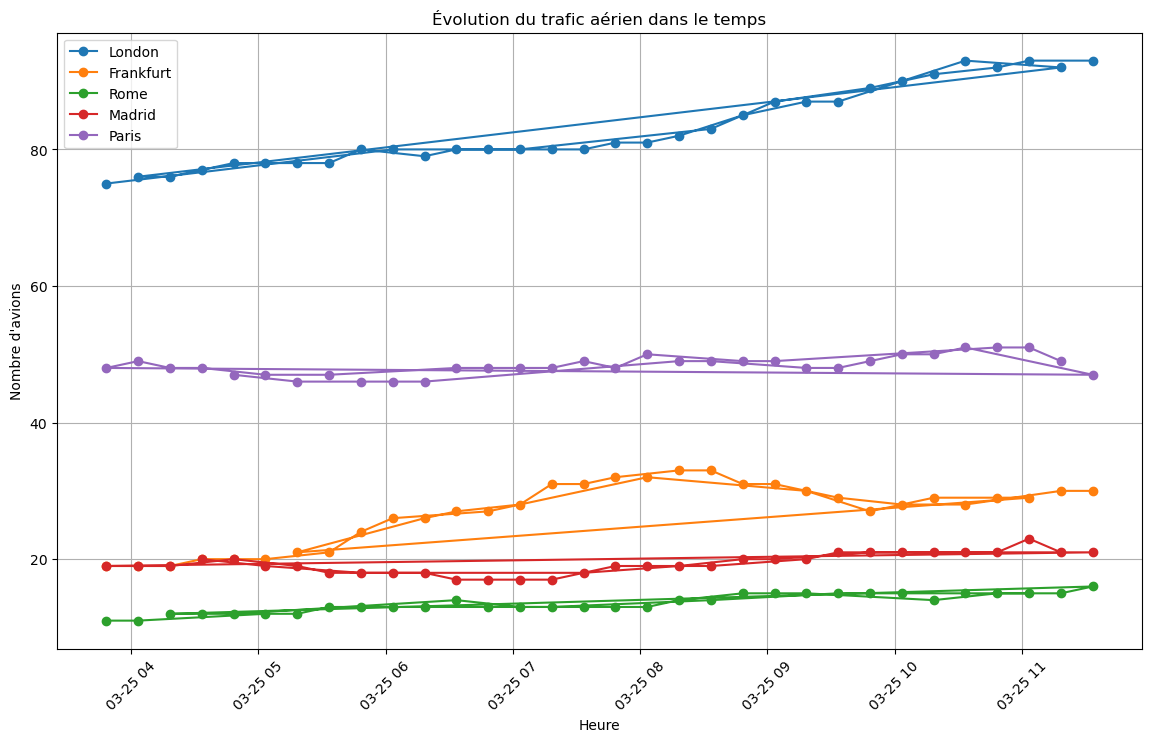

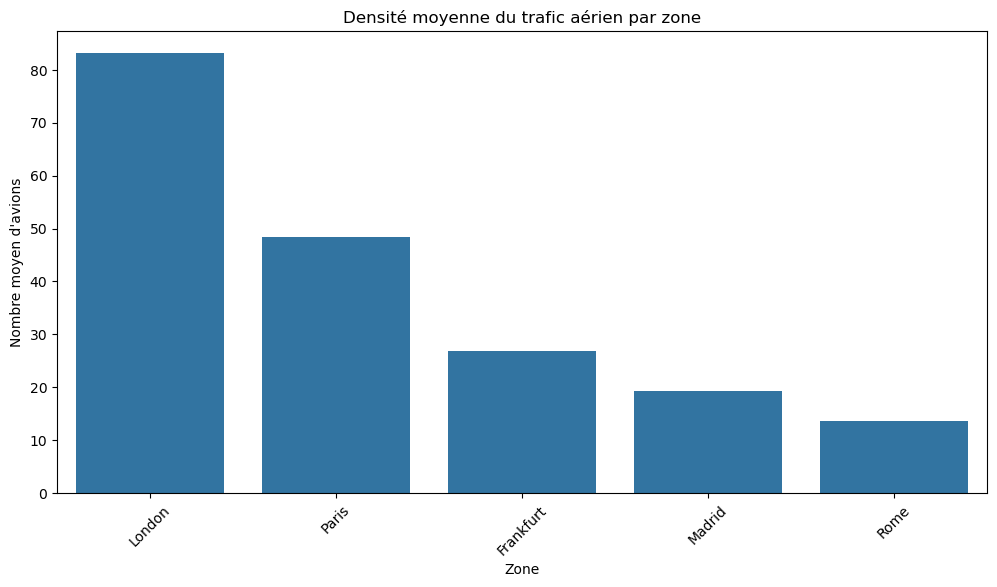

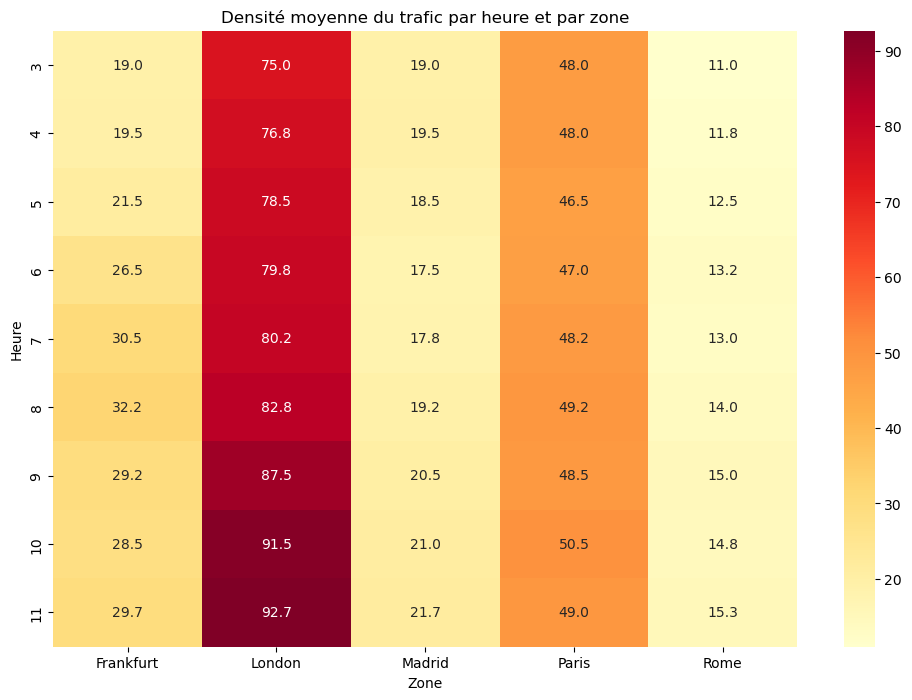

In [18]:
if __name__ == "__main__":
    main()

### Observations 

- La zone de London se distingue nettement comme la plus congestionnée En comparaison. 
- Paris présente un trafic plus modéré mais stable suggérant une activité soutenue mais plus linéaire. 
- Frankfurt montre une tendance croissante ce qui peut correspondre à une montée progressive de l'activité au fil de la matinée. 
- Madrid et Rome enregistrent un trafic significativement plus faible ce qui peut refléter une activité aérienne plus locale ou moins centralisée. 

### Interprétations

- Optimiser la gestion de l’espace aérien.
- Anticiper les périodes de surcharge. 
- Mieux répartir les ressources aéroportuaires et de contrôle. 
- Mettre en lumière l’importance stratégique de certains hubs
- Envisager des actions d’optimisation ou d’alerte dans le cadre d’une surveillance temps réel.